In [153]:
# !pip install scikit-learn --upgrade

In [154]:
import pandas as pd
import numpy as np
from ast import literal_eval
from sklearn.preprocessing import MultiLabelBinarizer, OneHotEncoder, StandardScaler
from dateutil.parser import parse
from matplotlib import pyplot as plt
import seaborn as sns

In [155]:
class Config():
  def __init__(
    self,
    num_classes,
    num_epochs,
    batch_size,
    early_stopping_patience,
    early_stopping_min_delta,
    use_saved_models,
    train_size,
    test_size,
    val_size,
  ):
    self.num_classes = num_classes
    self.num_epochs = num_epochs
    self.batch_size = batch_size
    self.early_stopping_patience = early_stopping_patience
    self.early_stopping_min_delta = early_stopping_min_delta

    self.use_saved_models = use_saved_models
    
    self.train_size = train_size
    self.test_size = test_size
    self.val_size = val_size

cfg = Config(
    num_classes=4,
    num_epochs=50,
    batch_size = 16,
    early_stopping_patience = 10,
    early_stopping_min_delta = 0.01,
    use_saved_models = False,
    train_size = 0.9,
    test_size = 0.05,
    val_size = 0.05,
)

# Описание задачи

Решается задача многоклассовой классификаций, в рамках которой каждому фильму сопоставляется класс на основании его кассовых сборов. Важно заметить, что в других исследованиях (например, [тут](https://www.researchgate.net/publication/322138608_A_Machine_Learning_Approach_to_Predict_Movie_Box-Office_Success) и [тут](https://www.semanticscholar.org/reader/3925582b25c9896b1373100290556396534e55e6)) для определения класса фильма используются диапазоны с аболютными значениями в денежных единицах. Напротив, в данном исследовании диапазоны будут определятся бюджетом фильма. Это связано с тем, что дорогой фильм (300 млн. у.е.) с широкомастабной рекламной компанией, собравший огромную кассу (700 млн. у.е.) по сравнению с другими фильмами, может оказаться убыточным. С другой стороны, малобюджетный фильм (например, 1 млн у.е.) может собрать относительно скромную кассу (20 млн. у.е.), но при этом оказаться очень прибыльным. Все это связнао с тем, что, создатели фильма получают не всю сумму сборов, часть распределяется между различными участниками рынка (кинотеатры/дистриьюторы и агенты), часть уходит на рекламу и маркетинг, часть уплачивается как налог ([источник](https://stephenfollows.com/how-a-cinemas-box-office-income-is-distributed/)). В данном исследовании принято, что кинотеатры и дистрибьюторы забирают 50% от сборов, затраты на рекламу и маркетинг равны 0.

В данной работае выделены следующие классы (P - revenue - сборы, B - budget - бюджет):
* 0: R < 1\*B
* 1: 1\*B <= R < 2\*B
* 2: 2\*B <= R < 4\*B
* 3: 4\*B <= R

# Методы оценки
* Exact match
* 1-class-away accuracy

# Обработка данных

In [156]:
df = pd.read_csv('./movie_dataset.csv', index_col=0)

## Очистка данных

В исходном наборе данных имеются поля, которые не понадобятся при обучении:
* Идентификаторы в самом наборе данных (`id`)
* Слоган (`tagline`)
* Краткое описание фильма (`overview`)
* Количество оценок (`vote_count`) и средняя оценка (`vote_average`), поскольку в данной работе прогнозирование проводится по данным, известным до выхода фильма в прокат
* Сборы на первой неделе в стране-производителе фильма (`domestic_opening`)
* Оригинальное название (`original_title`) и просто название (`title`)
* Языки, на котором разговаривают персонажи фильма (`spoken_languages`)

In [157]:
to_drop = ['id', 'tagline', 'overview', 'vote_average', 'vote_count', 'domestic_opening', 'original_title', 'title', 'spoken_languages']
df = df.drop(columns=to_drop)

In [158]:
df.dtypes

genres                  object
imdb_id                 object
original_language       object
production_companies    object
production_countries    object
release_date            object
runtime                  int64
status                  object
domestic_distributor    object
mpaa                    object
budget                   int64
revenue                  int64
actors                  object
director                object
poster                  object
dtype: object

Удаляем строки, в которых есть хотя бы один признак без значения

In [159]:
df['budget'] = df['budget'].replace({0: np.NAN})
df['revenue'] = df['revenue'].replace({0: np.NAN})
df['runtime'] = df['runtime'].replace({0: np.NAN})

df.dropna(inplace=True)

Также удалим все фильмы, которые не выпущены в прокат. Затем удалим аттрибут, связанный с этой информацией (`status`)

In [160]:
df = df[df['status'] == 'Released']
df = df.drop(columns=['status'], axis=1)

## Формирование целевой переменной

Сформируем целевую переменную по имеющимся бюджету и сборам. Правила соотнесения сборов и класса приведены выше в описании задачи.

In [161]:
def get_class(row):
  R = row['revenue']
  B = row['budget']
  if R < B:
    return 0
  elif B <= R < 2*B:
    return 1
  elif 2*B <= R < 4*B:
    return 2
  elif 4*B <= R:
    return 3
  return np.NAN

df['target'] = df.apply(get_class, axis=1)

In [162]:
df['target'].value_counts()

target
0    1473
2    1018
3     903
1     837
Name: count, dtype: int64

Видно, что классы сбалансированы.

## Извлечение и преобразование признаков

При обучении модели будут использоваться следующие признаки:
* Жанры
* Язык картины
* Продюсерская компания
* Страна производства
* Месяц выхода
* Продолжительность
* Компания-дистрибьютор фильма в стране производства
* Возрастной рейтинг фильма
* Бюджет
* Актеры
* Режиссер

Выделяем категориальные и непрерывные признаки

In [163]:
cont = ['runtime', 'budget']
categ = []
for col in df.columns:
  if col not in cont:
    categ.append(col)

### Категориальные признаки

Посчитаем количество возможных значений у категориальных переменных, но сначала преобразуем сырые строки в Python-объекты для некоторых полей.

In [164]:
literal_eval_cols = ['genres', 'production_countries', 'production_companies', 'actors']

for col in literal_eval_cols:
    df[col] = df.apply(lambda x: literal_eval(x[col]), axis=1)

In [165]:
for cat in categ:
  print(cat, df[cat].explode().nunique())

genres 19
imdb_id 4082
original_language 30
production_companies 4544
production_countries 75
release_date 2790
domestic_distributor 209
mpaa 10
revenue 4046
actors 4170
director 1799
poster 4082
target 4


#### Жанры

Всего в датасете присутствуют 19 различных жанров: триллер, музыка, мистика, драма, история, криминал, документальный, военный, зарубежный, ужасы, экшн, комедия, фантастика, романтика, приключения, семейный, анимация, научная фантастика, вестерн. Причем фильму могут соответсвовать несколько жанров. Поэтому данный признак будет кодироваться следующим образом:
1. Вектор длины 19 заполняется нулями, каждая позиция которого соответствует одному определенному жанру.
2. Проставляются единицы в тех позициях, которые соответствуют жанрам фильма.

In [166]:
mlb = MultiLabelBinarizer()
dum = mlb.fit_transform(df['genres'])
classes = ['genre_' + x.replace(' ', '_').lower() for x in mlb.classes_]
df = df.join(pd.DataFrame(dum.astype(bool), df.index, classes))

genres = set(mlb.classes_)
print('Количество жанров:', len(genres))
print('Жанры: ', genres)

df = df.drop(columns=['genres'], axis=1)

Количество жанров: 19
Жанры:  {'Drama', 'Family', 'Comedy', 'Romance', 'Documentary', 'Action', 'History', 'Western', 'Foreign', 'Music', 'Mystery', 'Crime', 'Science Fiction', 'Horror', 'Animation', 'Fantasy', 'War', 'Thriller', 'Adventure'}


#### Оригинальный язык

In [167]:
df['original_language'].value_counts()

original_language
en    3976
fr      67
es      33
zh      21
de      14
ja      14
ko      13
da      12
it      11
fa      10
cn       8
pt       7
ru       7
sv       5
nl       5
hi       5
no       4
hu       3
he       3
th       2
id       2
nb       1
tr       1
pl       1
cs       1
fi       1
af       1
ps       1
bs       1
ro       1
Name: count, dtype: int64

В датасете преобладают фильмы на английском языке, поэтому данный признак будет кодироваться так: если фильм на английском, то 1, иначе 0.

In [168]:
df['original_language'] = df.apply(lambda row: 1 if row['original_language'] == 'en' else 0, axis=1)

#### Продюсерская компания

Данный признак представлен в виде массива, т.к. при создании фильма могут участвовать несколько компаний. Также в исходном датасете очень много различных компаний (4711), поэтому здесь не получится применить ту же технику, что и для жанров, поскольку в таком случае датасет будет сильно разреженным, что может ухудшить точность модели. Посмотрим, как часто встречаются те или иные компаний.

In [169]:
df['production_companies'].explode().value_counts()

production_companies
Warner Bros.                                            347
Universal Pictures                                      301
Paramount Pictures                                      260
Twentieth Century Fox Film Corporation                  216
Columbia Pictures                                       197
                                                       ... 
Munich Film Partners & Company (MFP) MI2 Productions      1
Hi-Rez Films                                              1
Battlefield Productions                                   1
JTP Films                                                 1
Non-Stop Productions                                      1
Name: count, Length: 4544, dtype: int64

Признак будет кодироваться следующим образом:
1. Для каждой компании будут просуммированы кассовые сборы всех фильмов, в продюсировании которых они принимали участие.
2. Массив компаний будет кодироваться суммой числовых значений, полученных в п. 1.

In [170]:
def cumulative_revenue_replacer(column, iterable=True):
  entities = df[column].explode().tolist()
  entities_revenue = {}
  for e in entities:
    entities_revenue[e] = 0

  for index, row in df.iterrows():
    if iterable:
      for e in row[column]:
        entities_revenue[e] += row['revenue']
    else:
      entities_revenue[row[column]] += row['revenue']

  def entity_to_cumulative_revenue(entity):
    return entities_revenue[entity]

  def f(row):
    if iterable:
      return sum(list(map(entity_to_cumulative_revenue, row[column])))
    else:
      return entities_revenue[row[column]]

  return f

df['production_companies'] = df.apply(cumulative_revenue_replacer('production_companies'), axis=1)

#### Страна производства

In [171]:
df['production_countries'].explode().value_counts()

production_countries
US    3727
GB     573
FR     341
DE     341
CA     216
      ... 
AW       1
AF       1
BS       1
MY       1
PA       1
Name: count, Length: 75, dtype: int64

Данный признак будет кодироваться так же, как и признак "Продюсерская компания"

In [172]:
df['production_countries'] = df.apply(cumulative_revenue_replacer('production_countries'), axis=1)

#### Месяц выхода

Сначала необходимо извлечь месяц выхода фильма

In [173]:
m = df.apply(lambda x: parse(x['release_date']).month, axis=1)
df = df.join(m.rename('release_month'))
df = df.drop(columns=['release_date'], axis=1)

Месяц выхода будет закодирован с помощью техники one-hot encoding, т.к. количество возможных значений (12) не велико.

In [174]:
one_hot_enc = OneHotEncoder(sparse_output=False)

mpaa_encoded = one_hot_enc.fit_transform(df[['release_month']])
classes = [f'release_month_{x}' for x in one_hot_enc.categories_[0]]
df = df.join(pd.DataFrame(mpaa_encoded.astype(bool), df.index, classes))

df = df.drop(columns=['release_month'], axis=1)

#### Компания-дистрибьютор фильма в стране производства

In [175]:
df['domestic_distributor'].explode().value_counts()

domestic_distributor
Warner Bros.                           464
Twentieth Century Fox                  335
Universal Pictures                     330
Sony Pictures Releasing                290
Walt Disney Studios Motion Pictures    288
                                      ... 
Tribeca Films                            1
Four of a Kind Productions               1
Peninsula Films                          1
Kit Parker Films                         1
Fabrication Films                        1
Name: count, Length: 209, dtype: int64

В датасете 215 возможных значений для данного признака (не применима техника one hot encoding). У каждого фильма ровно 1 дистрибьютор (в рамках датасета). Таким образом, применим использованную ранее технику кодирования с заменой дистриьютора на его суммарные сборы (см. "Продюсерская компания" и "Страна производства").

In [176]:
df['domestic_distributor'] = df.apply(cumulative_revenue_replacer('domestic_distributor', iterable=False), axis=1)

#### Возрастной рейтинг

In [177]:
df['mpaa'].value_counts()

mpaa
R            2135
PG-13        1429
PG            599
G              43
NC-17          15
M/PG            3
GP              3
Not Rated       2
Approved        1
M               1
Name: count, dtype: int64

Количество классов мало, поэтому можно применить one hot encoding. Однако есть классы, к которым принадлежит небольшое количество фильмов. Удалим классы, у которых меньше 15 экземпляров: `M/PG`, `GP`, `Approved`, `M` и `Not Rated`. Это позволит уменьшить разреженность итогового датасета.

In [178]:
to_delete = ['M/PG', 'GP', 'Approved', 'M', 'Not Rated']
df = df[~df['mpaa'].isin(to_delete)]

Применим one hot encoding

In [179]:
one_hot_enc = OneHotEncoder(sparse_output=False)

mpaa_encoded = one_hot_enc.fit_transform(df[['mpaa']])
classes = [('mpaa_' + x.upper()) for x in one_hot_enc.categories_[0]]
df = df.join(pd.DataFrame(mpaa_encoded.astype(bool), df.index, classes))

df = df.drop(columns=['mpaa'], axis=1)

#### Актёры

У фильмов может быть любое количество актеров. В рамках данной работы ограничимся первыми тремя актерами, которые указываются в титрах.

In [180]:
df.apply(lambda row: len(row['actors']), axis=1).value_counts()

3    4212
2       4
0       3
1       2
Name: count, dtype: int64

Удалим строки, где количество актеров меньше 3

In [181]:
df = df[df['actors'].map(len) == 3]

Сначала каждый актер будет помещен в свой столбец, а затем применим технику с заменой имени актёра на сумму кассовых сборов всех его фильмов.

In [182]:
df = df.join(pd.DataFrame(df['actors'].values.tolist(), df.index, ['actor_1', 'actor_2', 'actor_3']))
df = df.drop(['actors'], axis=1)

In [183]:
df['actor_1'] = df.apply(cumulative_revenue_replacer('actor_1', iterable=False), axis=1)
df['actor_2'] = df.apply(cumulative_revenue_replacer('actor_2', iterable=False), axis=1)
df['actor_3'] = df.apply(cumulative_revenue_replacer('actor_3', iterable=False), axis=1)

#### Режиссер

Аналогично закодируем режиссёра фильма

In [184]:
df['director'] = df.apply(cumulative_revenue_replacer('director', iterable=False), axis=1)

### Непрерывные признаки

Добавим к уже имеющимся непрерывным признакам те, которые были получены в процессе обработки категориальных признаков.

In [185]:
cont = cont + ['production_companies', 'production_countries', 'domestic_distributor', 'actor_1', 'actor_2', 'actor_3', 'director']

Посмотрим, какое распределение у непрерывных признаков

array([[<Axes: title={'center': 'runtime'}>,
        <Axes: title={'center': 'budget'}>,
        <Axes: title={'center': 'production_companies'}>],
       [<Axes: title={'center': 'production_countries'}>,
        <Axes: title={'center': 'domestic_distributor'}>,
        <Axes: title={'center': 'actor_1'}>],
       [<Axes: title={'center': 'actor_2'}>,
        <Axes: title={'center': 'actor_3'}>,
        <Axes: title={'center': 'director'}>]], dtype=object)

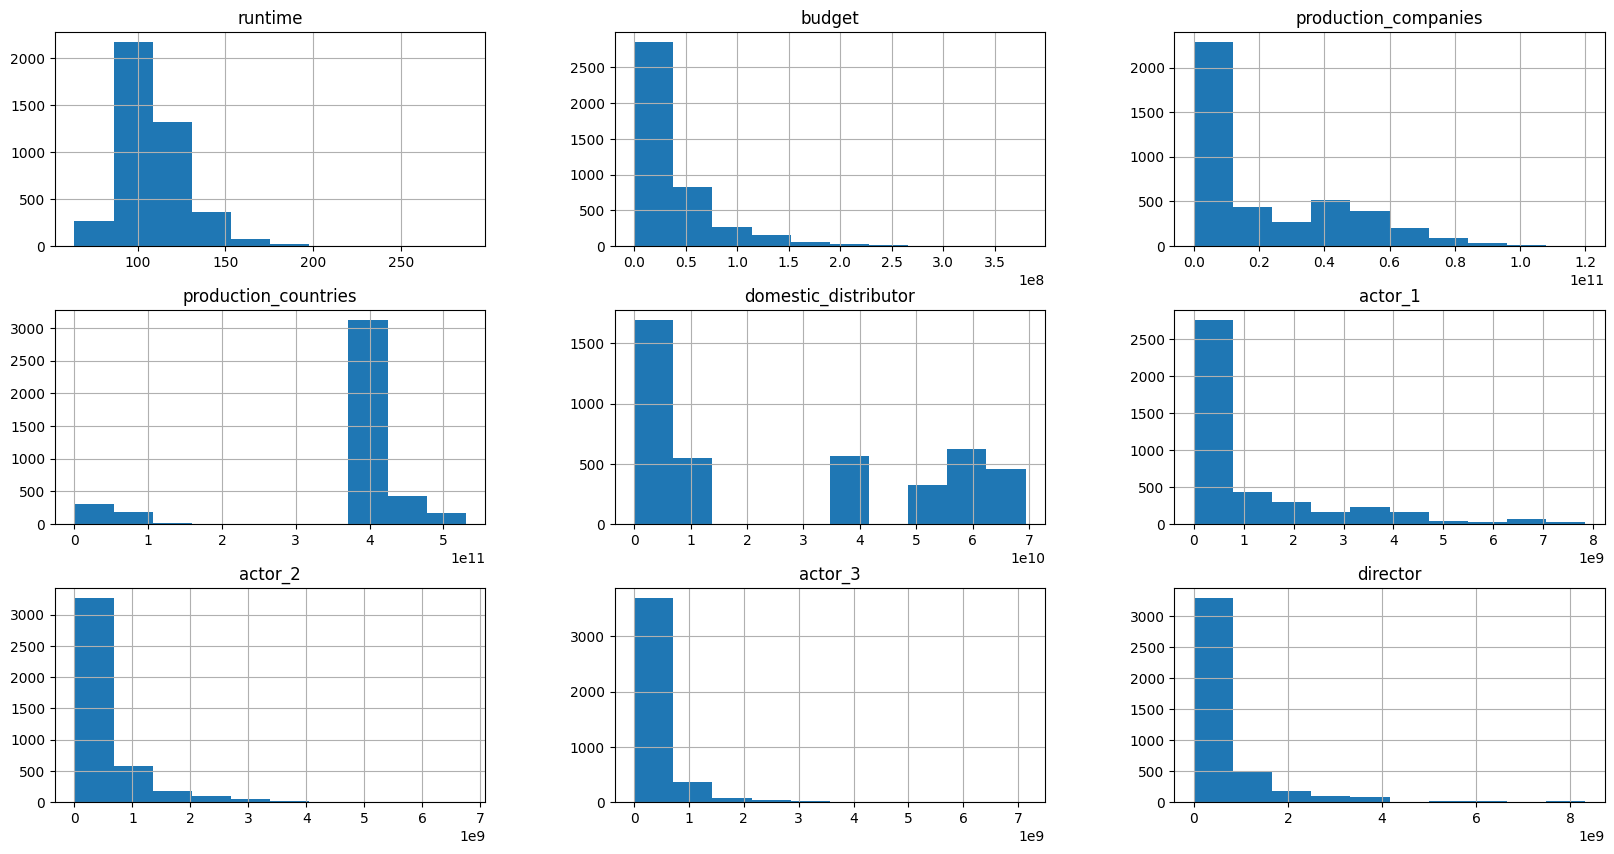

In [186]:
df.hist(cont, figsize=(20, 10))

Видно, что продолжительность (`runtime`) имеет распределение, близкое к нормальноу, а бюджет (`budget`) - степенное.

In [187]:
for col in cont:
    scaler = StandardScaler()
    # scaler = QuantileTransformer(output_distribution='normal', random_state=0)
    df[col] = scaler.fit_transform(df[[col]])

array([[<Axes: title={'center': 'runtime'}>,
        <Axes: title={'center': 'budget'}>,
        <Axes: title={'center': 'production_companies'}>],
       [<Axes: title={'center': 'production_countries'}>,
        <Axes: title={'center': 'domestic_distributor'}>,
        <Axes: title={'center': 'actor_1'}>],
       [<Axes: title={'center': 'actor_2'}>,
        <Axes: title={'center': 'actor_3'}>,
        <Axes: title={'center': 'director'}>]], dtype=object)

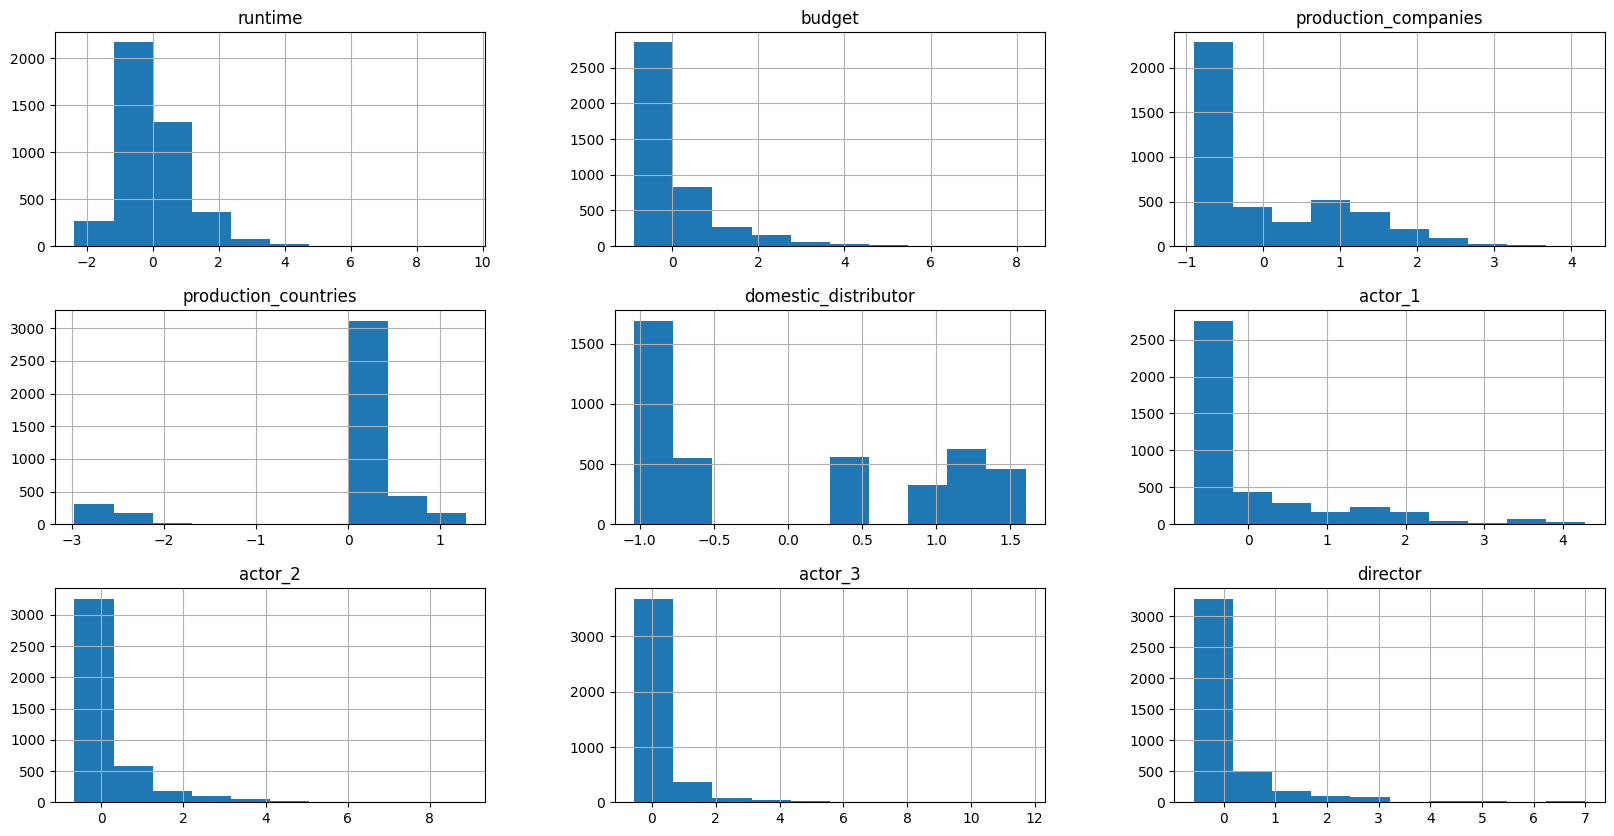

In [188]:
df.hist(cont, figsize=(20, 10))

Приведение данных к виду, пригодному для обучения модели

In [189]:
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.utils import to_categorical

target = df['target']

class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(target), y=target)
class_weights = {i: x for i, x in enumerate(class_weights)}

# y = to_categorical(target)
y = target.to_numpy()
X = df.drop(['imdb_id', 'revenue', 'target', 'poster'], axis=1).values.astype(float)

## В виде одной функции

In [190]:
def prepare_df():
    df = pd.read_csv('./movie_dataset.csv', index_col=0)
    df = df.drop(columns=['id', 'tagline', 'overview', 'vote_average', 'vote_count', 'domestic_opening', 'original_title', 'title', 'spoken_languages'])

    df['budget'] = df['budget'].replace({0: np.NAN})
    df['revenue'] = df['revenue'].replace({0: np.NAN})
    df['runtime'] = df['runtime'].replace({0: np.NAN})

    df.dropna(inplace=True)

    df = df[df['status'] == 'Released']
    df = df.drop(columns=['status'], axis=1)

    def get_class(row):
        R = row['revenue']
        B = row['budget']
        if R < B:
            return 0
        elif B <= R < 2*B:
            return 1
        elif 2*B <= R < 4*B:
            return 2
        elif 4*B <= R:
            return 3
        return np.NAN

    df['target'] = df.apply(get_class, axis=1)

    cont = ['runtime', 'budget']
    categ = []
    for col in df.columns:
        if col not in cont:
            categ.append(col)

    literal_eval_cols = ['genres', 'production_countries', 'production_companies', 'actors']

    for col in literal_eval_cols:
        df[col] = df.apply(lambda x: literal_eval(x[col]), axis=1)

    mlb = MultiLabelBinarizer()
    dum = mlb.fit_transform(df['genres'])
    classes = ['genre_' + x.replace(' ', '_').lower() for x in mlb.classes_]
    df = df.join(pd.DataFrame(dum.astype(bool), df.index, classes))

    genres = set(mlb.classes_)

    df = df.drop(columns=['genres'], axis=1)

    df['original_language'] = df.apply(lambda row: 1 if row['original_language'] == 'en' else 0, axis=1)

    def cumulative_revenue_replacer(column, iterable=True):
        entities = df[column].explode().tolist()
        entities_revenue = {}
        for e in entities:
            entities_revenue[e] = 0

        for index, row in df.iterrows():
            if iterable:
                for e in row[column]:
                    entities_revenue[e] += row['revenue']
            else:
                entities_revenue[row[column]] += row['revenue']

        def entity_to_cumulative_revenue(entity):
            return entities_revenue[entity]

        def f(row):
            if iterable:
                return sum(list(map(entity_to_cumulative_revenue, row[column])))
            else:
                return entities_revenue[row[column]]

        return f

    df['production_companies'] = df.apply(cumulative_revenue_replacer('production_companies'), axis=1)
    df['production_countries'] = df.apply(cumulative_revenue_replacer('production_countries'), axis=1)

    m = df.apply(lambda x: parse(x['release_date']).month, axis=1)
    df = df.join(m.rename('release_month'))
    df = df.drop(columns=['release_date'], axis=1)

    one_hot_enc = OneHotEncoder(sparse_output=False)

    mpaa_encoded = one_hot_enc.fit_transform(df[['release_month']])
    classes = [f'release_month_{x}' for x in one_hot_enc.categories_[0]]
    df = df.join(pd.DataFrame(mpaa_encoded.astype(bool), df.index, classes))
    
    df = df.drop(columns=['release_month'], axis=1)

    df['domestic_distributor'] = df.apply(cumulative_revenue_replacer('domestic_distributor', iterable=False), axis=1)
    to_delete = ['M/PG', 'GP', 'Approved', 'M', 'Not Rated']
    df = df[~df['mpaa'].isin(to_delete)]

    one_hot_enc = OneHotEncoder(sparse_output=False)

    mpaa_encoded = one_hot_enc.fit_transform(df[['mpaa']])
    classes = [('mpaa_' + x.upper()) for x in one_hot_enc.categories_[0]]
    df = df.join(pd.DataFrame(mpaa_encoded.astype(bool), df.index, classes))

    df = df.drop(columns=['mpaa'], axis=1)

    df.apply(lambda row: len(row['actors']), axis=1).value_counts()

    df = df[df['actors'].map(len) == 3]

    df = df.join(pd.DataFrame(df['actors'].values.tolist(), df.index, ['actor_1', 'actor_2', 'actor_3']))
    df = df.drop(['actors'], axis=1)

    df['actor_1'] = df.apply(cumulative_revenue_replacer('actor_1', iterable=False), axis=1)
    df['actor_2'] = df.apply(cumulative_revenue_replacer('actor_2', iterable=False), axis=1)
    df['actor_3'] = df.apply(cumulative_revenue_replacer('actor_3', iterable=False), axis=1)

    df['director'] = df.apply(cumulative_revenue_replacer('director', iterable=False), axis=1)

    cont = cont + ['production_companies', 'production_countries', 'domestic_distributor', 'actor_1', 'actor_2', 'actor_3', 'director']

    for col in cont:
        scaler = StandardScaler()
        # scaler = QuantileTransformer(output_distribution='normal', random_state=0)
        df[col] = scaler.fit_transform(df[[col]])
    
    target = df['target']
    df = df.drop(['imdb_id', 'revenue', 'target', 'poster'], axis=1)
    return df, target

def prepare_data(df, target):
    class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(target), y=target)
    class_weights = {i: x for i, x in enumerate(class_weights)}

    # y = to_categorical(target)
    y = target.to_numpy()
    X = df.values.astype(float)

    return X, y, class_weights

# Построение и обучение модели

Опишем фукнцию, которая будет оценивать получившуюся модель

In [191]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, f1_score

results = {}

# Функция для оценки полученной модели
def inspect_model(model, X, y, model_name, history=None):
  predictions = model.predict(X)
  # real_classes = y.argmax(axis=1)
  real_classes = y
  predicted_classes = predictions.argmax(axis=1)

  # Exact and 1-class-away accuracy
  diffs = abs(real_classes - predicted_classes)

  exact_match = len(diffs[diffs <= 0]) / len(diffs)
  one_class_away = len(diffs[diffs <= 1]) / len(diffs)
  print('Exact match accuracy:', exact_match)
  print('One class away accuracy:', one_class_away)

  # Precision and recall
  precision = precision_score(real_classes, predicted_classes, average=None)
  recall = recall_score(real_classes, predicted_classes, average=None)
  f1 = f1_score(real_classes, predicted_classes, average=None)
  print("Precision per class:", precision)
  print("Recall per class:", recall)
  print("F1 score per class", f1)

  # Macro and Micro averaged Precision and Recall
  macro_precision = precision_score(real_classes, predicted_classes, average='macro')
  macro_recall = recall_score(real_classes, predicted_classes, average='macro')
  micro_precision = precision_score(real_classes, predicted_classes, average='micro')
  micro_recall = recall_score(real_classes, predicted_classes, average='micro')
  macro_f1 = f1_score(real_classes, predicted_classes, average='macro')
  micro_f1 = f1_score(real_classes, predicted_classes, average='micro')

  print("Macro Precision:", macro_precision)
  print("Macro Recall:", macro_recall)
  print("Macro F1:", macro_f1)
  print("Micro Precision:", micro_precision)
  print("Micro Recall:", micro_recall)
  print("Micro F1:", micro_f1)
  
  # Confusion matrix
  m = confusion_matrix(real_classes, predicted_classes)
  ConfusionMatrixDisplay(m).plot()

  if (history != None):
    fig = plt.figure()
    ax = fig.add_subplot()
    ax.plot(history.history['val_loss'])
    ax.set_title('Loss Function Over Epochs')
    ax.set_ylabel('Sparse Categorical Crossentropy value')
    ax.set_xlabel('No. epoch')
    plt.show()

    fig = plt.figure()
    ax = fig.add_subplot()
    ax.plot(history.history['val_accuracy'])
    ax.set_title('Accuracy Over Epochs')
    ax.set_ylabel('Accuracy value')
    ax.set_xlabel('No. epoch')
    plt.show()

  results[model_name] = {
      'exact_match': exact_match,
      'one_class_away': one_class_away,
  }

Разбиваем исходный датасет следующим образом: 90% - тренировочный, 5% - валидационный, 5% - тестовый.

In [192]:
from sklearn.model_selection import train_test_split

X_train, X_dum, y_train, y_dum = train_test_split(X, y, test_size=1-cfg.train_size, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_dum, y_dum, test_size=cfg.test_size/(cfg.test_size + cfg.val_size), stratify=y_dum)

print('Train size:', cfg.train_size)
print('Test size:', (1-cfg.train_size) * cfg.test_size/(cfg.test_size + cfg.val_size))
print('Val size:', (1-cfg.train_size) * cfg.val_size/(cfg.test_size + cfg.val_size))

print('Train size:', X_train.shape)
print('Test size:', X_test.shape)
print('Val size:', X_val.shape)

Train size: 0.9
Test size: 0.04999999999999999
Val size: 0.04999999999999999
Train size: (3790, 46)
Test size: (211, 46)
Val size: (211, 46)


## Архитектура модели

In [193]:
from keras import layers
from keras.models import Model

def build_model(input_shape, num_classes):
    input = layers.Input(shape=input_shape)
    hidden = layers.Dense(32, activation='relu')(input)
    hidden = layers.Dense(64, activation='relu')(hidden)
    hidden = layers.Dense(128, activation='relu')(hidden)
    hidden = layers.Dense(64, activation='relu')(hidden)
    hidden = layers.Dense(32, activation='relu')(hidden)
    output = layers.Dense(num_classes, activation='softmax')(hidden)

    model = Model(inputs=input, outputs=output)

    return model

In [194]:
from keras.utils import plot_model

# plot_model(build_model((X_train.shape[1],), cfg.num_classes), show_shapes=True, show_layer_activations=True)

## Поиск оптимальных парметров обучения с помощью HalvingGridSearchCV

In [195]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard
from keras.models import load_model
from sklearn.experimental import enable_halving_search_cv
from scikeras.wrappers import KerasClassifier

from sklearn.model_selection import HalvingGridSearchCV

def find_optimal_hyperparameters():
    def create_model():
        return build_model((X_train.shape[1],), cfg.num_classes)

    # Настраиваем callback для ранней остановки модели
    early_stopping = EarlyStopping(monitor="val_loss", min_delta=cfg.early_stopping_min_delta, patience=cfg.early_stopping_patience)

    model = KerasClassifier(
        build_fn=create_model,
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy'],
        epochs=cfg.num_epochs,
        class_weight=class_weights,
        callbacks=[
            early_stopping,
        ],
        validation_split=0.1,
    )

    params = {
        'optimizer': ['adam', 'adamw', 'adadelta', 'adagrad'],
        'batch_size': [16, 32, 64],
        "optimizer__learning_rate": [0.001, 0.01, 0.1]
    }
    grid = HalvingGridSearchCV(
        estimator=model, 
        param_grid=params,
        scoring='accuracy',
        factor=3,
        cv=5,
        n_jobs=10,
    )

    grid_result = grid.fit(X_train, y_train)

    return grid_result

    

Запуск поиска оптимальных гиперпараметров для модели

In [196]:
# grid_result = find_optimal_hyperparameters()
# print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
# Best: 0.434656 using {'batch_size': 32, 'optimizer': 'adagrad', 'optimizer__learning_rate': 0.01}

Построение графика процесса поиска оптимальных параметров

In [197]:
def plot_grid_result(grid_result):
    results = pd.DataFrame(grid_result.cv_results_)
    results["params_str"] = results.params.apply(str)
    results.drop_duplicates(subset=("params_str", "iter"), inplace=True)
    mean_scores = results.pivot(
        index="iter", columns="params_str", values="mean_test_score"
    )
    ax = mean_scores.plot(legend=False, alpha=0.6)

    labels = [
        f"iter={i}\nn_samples={grid_result.n_resources_[i]}\nn_candidates={grid_result.n_candidates_[i]}"
        for i in range(grid_result.n_iterations_)
    ]

    ax.set_xticks(range(grid_result.n_iterations_))
    ax.set_xticklabels(labels, rotation=45, multialignment="left")
    ax.set_title("Scores of candidates over iterations")
    ax.set_ylabel("mean test score", fontsize=15)
    ax.set_xlabel("iterations", fontsize=15)
    plt.tight_layout()
    plt.show()

# plot_grid_result(grid_result)

## Обучение модели

In [198]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard
from keras.models import load_model
from keras.optimizers import Adagrad

# Путь до лучшей модели
checkpoint_path = "./1-best-tabular-model.keras"

def train_model(X_train, y_train, X_val, y_val):
    m = build_model((X_train.shape[1],), cfg.num_classes)
    optimizer = Adagrad(
        learning_rate=0.01
    )
    m.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

    if (cfg.use_saved_models):
        return load_model(checkpoint_path), None

    checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_loss', save_best_only=True, mode='min', verbose=1)
    # Настраиваем callback для ранней остановки модели
    early_stopping = EarlyStopping(monitor="val_loss", min_delta=cfg.early_stopping_min_delta, patience=cfg.early_stopping_patience, verbose=1)
    # Настраиваем callback для TensorBoard
    tensorboard = TensorBoard(log_dir="./logs")

    # Обучение модели
    full_history = m.fit(
        X_train, y_train,
        epochs=cfg.num_epochs,
        batch_size=cfg.batch_size,
        validation_data=(X_val, y_val),
        class_weight=class_weights,
        verbose=1,
        callbacks=[
            checkpoint,
            early_stopping,
            tensorboard,
        ],
    )
    best_model = load_model(checkpoint_path)

    return best_model, full_history

In [199]:
best_model, full_history = train_model(X_train, y_train, X_val, y_val)

Epoch 1/50
233/237 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3474 - loss: 1.3601
Epoch 1: val_loss improved from inf to 1.33131, saving model to ./1-best-tabular-model.keras
237/237 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.3477 - loss: 1.3601 - val_accuracy: 0.3649 - val_loss: 1.3313
Epoch 2/50
221/237 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3933 - loss: 1.3220
Epoch 2: val_loss improved from 1.33131 to 1.30890, saving model to ./1-best-tabular-model.keras
237/237 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3936 - loss: 1.3219 - val_accuracy: 0.3934 - val_loss: 1.3089
Epoch 3/50
232/237 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4053 - loss: 1.2965
Epoch 3: val_loss improved from 1.30890 to 1.28191, saving model to ./1-best-tabular-model.keras
237/237 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4053 - loss: 1.2964 - val_accuracy: 0.4171 - val_loss: 1.2819
Epoch 4/50
224/237 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4127 - loss: 1.2722
Epoch 4: val_loss 

## Исследование модели

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
Exact match accuracy: 0.4881516587677725
One class away accuracy: 0.8009478672985783
Precision per class: [0.58024691 0.28571429 0.47368421 0.49122807]
Recall per class: [0.64383562 0.23809524 0.35294118 0.62222222]
F1 score per class [0.61038961 0.25974026 0.40449438 0.54901961]
Macro Precision: 0.45771836999907173
Macro Recall: 0.4642735633066012
Macro F1: 0.4559109649988698
Micro Precision: 0.4881516587677725
Micro Recall: 0.4881516587677725
Micro F1: 0.4881516587677725


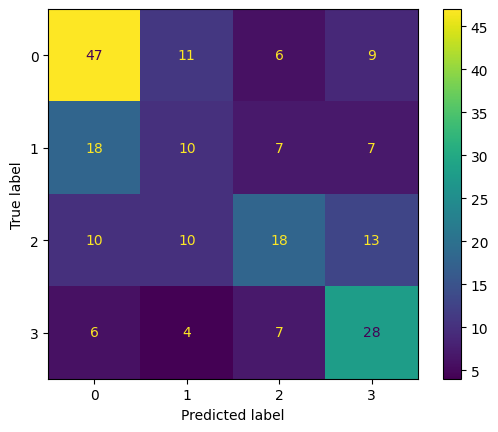

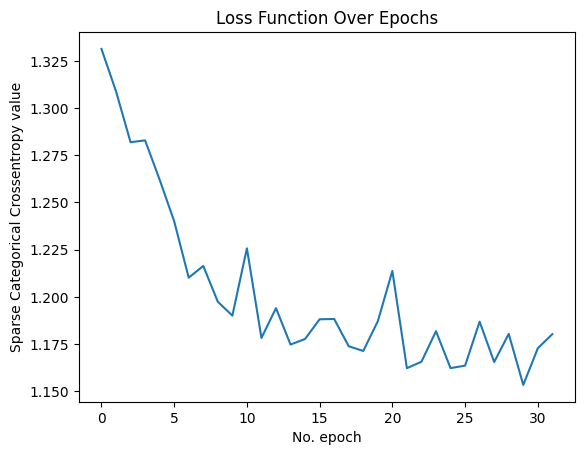

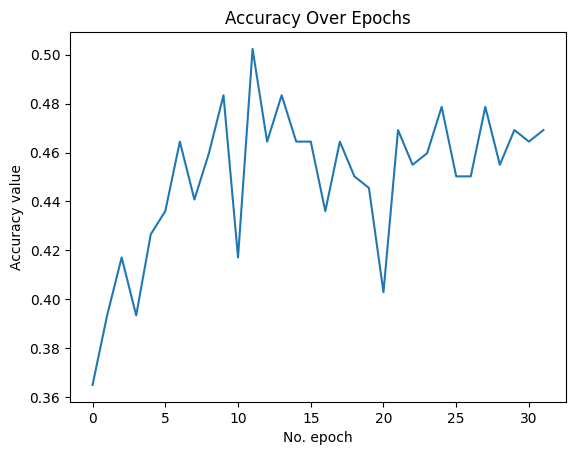

In [200]:
# Проверка лучшей модели
inspect_model(best_model, X_test, y_test, 'tabular', history=full_history)

In [201]:
# %load_ext tensorboard
# %tensorboard --logdir ./logs

## Permutation Feature Importance

Метод перестановочной важности признаков (permutation feature importance) представляет собой способ расчёта степени влияния каждого признака на прогнозы модели.
Достоинством метода является то, что он применим
* для любой модели (white-box, black-box models);
* для любой задачи (классификация, регрессия и др.);
* для любой функции потерь.

Таким образом, перестановочная важность признака показывает, во сколько/на сколько среднее качество прогнозов изменится, если модель не сможет использовать информацию, хранящуюся в этом признаке, при построении прогнозов.

[Источник](https://deepmachinelearning.ru/docs/Machine-learning/Complex-models-interpretation/Permutation-feature-importance)

In [202]:
def permutation_feature_importance(model, X_test, y_test, num_iter=10):
    baseline = model.evaluate(X_test, y_test)[1]

    indexes_to_permute = get_columns_indexes_to_permute()

    importance = {}
    for column, indexes in indexes_to_permute.items():
        importance[column] = []
        for _ in range(num_iter):
            X_permuted = X_test.copy()
            for idx in indexes:
                np.random.shuffle(X_permuted[:, idx])
            score = model.evaluate(X_permuted, y_test)[1]
            importance[column].append(score / baseline)
        
    for k, v in importance.items():
        importance[k] = np.array(v)

    return importance

def get_columns_indexes_to_permute():
    tmp_df, _ = prepare_df()

    column_prefixes_to_collapse = ['genre', 'release_month', 'mpaa', 'actor']
    columns = tmp_df.columns
    columns_indexes = {col: columns.get_loc(col) for col in columns}

    collapsed_columns_indexes = {c: [] for c in column_prefixes_to_collapse}

    for c, i in columns_indexes.items():
        if (any(c.startswith(p) for p in column_prefixes_to_collapse)):
            for p in column_prefixes_to_collapse:
                if (c.startswith(p)):
                    collapsed_columns_indexes[p].append(i)
                    break
        else:
            collapsed_columns_indexes[c] = [i]

    del tmp_df
    
    return collapsed_columns_indexes

In [203]:
# importance = permutation_feature_importance(best_model, X_test, y_test, num_iter=100)

Построение графика для "важности" признака.

Видно, что наиболее важными признаками являются бюджет, актеры, продюсерская компания и режиссер. Самыми не важными - язык оригинала и дистрибьютор.
На основе этого приянто решение по исключению этих признаков из датасета.

In [204]:
import matplotlib.pyplot as plt
import numpy as np

def plot_importance(importance):
    data = {
        k: [np.percentile(v, 5), np.mean(v), np.percentile(v, 95)] for k, v in importance.items()
    }

    # Создание списка названий признаков и списков с минимальными и максимальными значениями важности
    features = list(data.keys())
    features.sort(key=lambda k: data[k][1], reverse=True)
    min_values = [data[feature][0] for feature in features]
    mean_values = [data[feature][1] for feature in features]
    max_values = [data[feature][2] for feature in features]

    # Создание графика
    fig, ax = plt.subplots()

    # Построение полосок для каждого признака
    for i, feature in enumerate(features):
        ax.plot([min_values[i], max_values[i]], [i, i], color='black', linewidth=3)
        ax.plot(mean_values[i], i, 'ko')

    # Настройка осей и заголовков
    ax.set_ylim(-1, len(features))  # Установка границ по оси Y
    ax.set_yticks(range(len(features)))  # Установка меток на оси Y
    ax.set_yticklabels(features)  # Назначение названий признаков на оси Y
    ax.set_xlabel("Важность признака")  # Заголовок оси X

    # Отображение графика
    plt.show()

In [205]:
# plot_importance(importance)

## Удаление "неважных" признаков

In [207]:
columns_to_delete = ['original_language', 'domestic_distributor']
tmp_df, target = prepare_df()
tmp_df = tmp_df.drop(columns=columns_to_delete, axis=1)

X, y, class_weights = prepare_data(tmp_df, target)

del tmp_df

X_train, X_dum, y_train, y_dum = train_test_split(X, y, test_size=1-cfg.train_size, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_dum, y_dum, test_size=cfg.test_size/(cfg.test_size + cfg.val_size), stratify=y_dum)
best_model, full_history = train_model(X_train, y_train, X_val, y_val)

Epoch 1/50
230/237 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3271 - loss: 1.3717
Epoch 1: val_loss improved from inf to 1.32283, saving model to ./1-best-tabular-model.keras
237/237 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.3279 - loss: 1.3714 - val_accuracy: 0.3555 - val_loss: 1.3228
Epoch 2/50
225/237 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3883 - loss: 1.3163
Epoch 2: val_loss did not improve from 1.32283
237/237 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.3883 - loss: 1.3168 - val_accuracy: 0.3744 - val_loss: 1.3291
Epoch 3/50
226/237 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4122 - loss: 1.3051
Epoch 3: val_loss improved from 1.32283 to 1.30979, saving model to ./1-best-tabular-model.keras
237/237 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4123 - loss: 1.3049 - val_accuracy: 0.4028 - val_loss: 1.3098
Epoch 4/50
237/237 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4314 - loss: 1.2770
Epoch 4: val_loss improved from 1.30979 to 1.29131, saving model to 

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
Exact match accuracy: 0.45023696682464454
One class away accuracy: 0.7488151658767772
Precision per class: [0.53731343 0.43181818 0.4        0.4       ]
Recall per class: [0.49315068 0.45238095 0.23529412 0.62222222]
F1 score per class [0.51428571 0.44186047 0.2962963  0.48695652]
Macro Precision: 0.44228290366350065
Macro Recall: 0.45076199429543506
Macro F1: 0.434849749359355
Micro Precision: 0.45023696682464454
Micro Recall: 0.45023696682464454
Micro F1: 0.45023696682464454


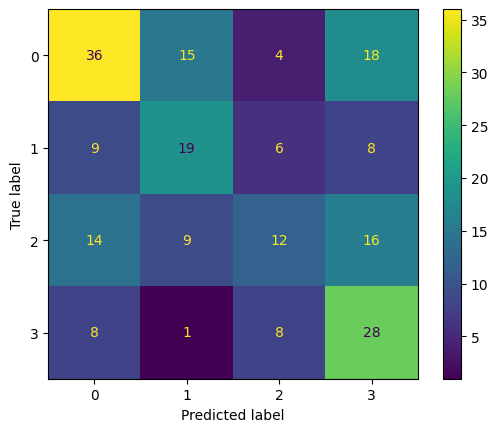

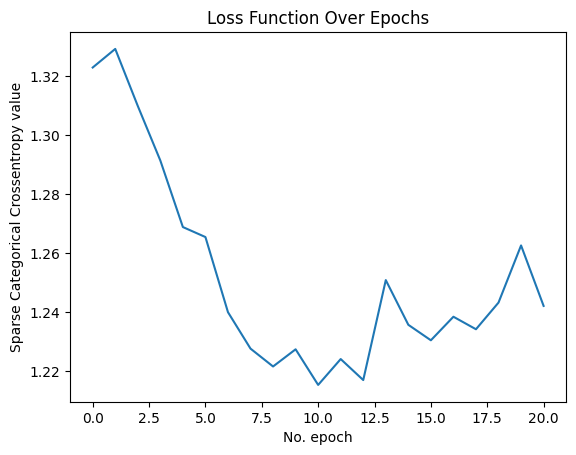

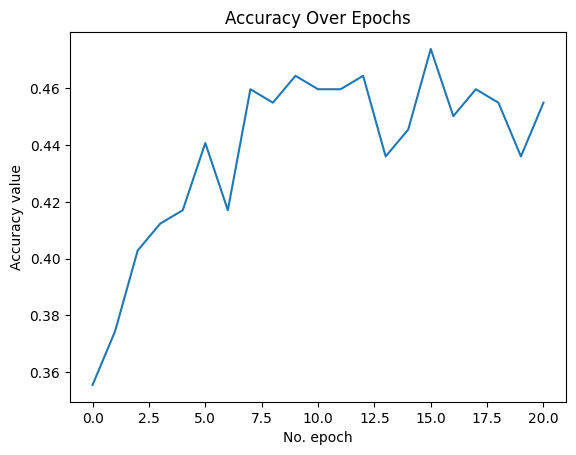

In [208]:
# Проверка лучшей модели
inspect_model(best_model, X_test, y_test, 'tabular', history=full_history)